<a href="https://colab.research.google.com/github/MrezaFd/Tugas-Besar-ML-059-055-/blob/main/Tugas_6_save_model%26plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import files #import lib
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hexazor","key":"663a14597732196faa9d3257dd4ff4df"}'}

In [3]:
!mkdir -p ~/.kaggle #membuat directory bernama kaggle 
!cp kaggle.json ~/.kaggle/ #copy file kaggle.json upload tadi ke directory baru
!chmod 600 ~/.kaggle/kaggle.json #berikan izin untuk file kaggle.jsonv

In [4]:
#Unduh dataset
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

100% 324M/325M [00:02<00:00, 148MB/s]
100% 325M/325M [00:02<00:00, 152MB/s]


In [5]:
from zipfile import ZipFile
file_name = "skin-cancer-malignant-vs-benign.zip"

with ZipFile(file_name,'r') as zip :
  zip.extractall()
  print('Berhasil')

Berhasil


In [6]:
!mkdir a

In [7]:
!mv -t a test train

In [8]:
# Definisikan path untuk data train dan data validation
import os
base_dir = '/content/a'


train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

In [9]:
import cv2
import numpy as np

# Gather data train
train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

In [10]:
# Gather data validation
val_data = []
val_label = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)

val_data = np.array(val_data)
val_label = np.array(val_label)

<h3>Data Preprocessing</h3>

In [11]:
# Tampilkan shape dari data train dan data validation
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (2637, 150, 150, 3)
Train Label =  (2637,)
Validation Data =  (660, 150, 150, 3)
Validation Label =  (660,)


In [12]:
# Normalisasi dataset
print("Data sebelum di-normalisasi ", train_data[0][0][0])

x_train = train_data.astype('float32') / 255.0
x_val = val_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_train[0][0][0])

Data sebelum di-normalisasi  [ 88 101 145]
Data setelah di-normalisasi  [0.34509805 0.39607844 0.5686275 ]


In [13]:
# Transformasi label encoder
from sklearn.preprocessing import LabelEncoder

print("Label sebelum di-encoder ", train_label[995:2005])

lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_val = lb.fit_transform(val_label)

print("Label setelah di-encoder ", y_train[995:2005])

Label sebelum di-encoder  ['malignant' 'malignant' 'malignant' ... 'benign' 'benign' 'benign']
Label setelah di-encoder  [1 1 1 ... 0 0 0]


<h3>Definisikan Model</h3>

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [39]:
# Feature Extraction Layer
model = Sequential()

model.add(InputLayer(input_shape=[150,150,3]))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Flatten())

In [40]:
# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [41]:
# Print model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 19, 19, 64)      

In [42]:
best_model_cancer_path = 'model-cancer.h5'
checkpoint_callback = ModelCheckpoint(best_model_cancer_path,
                                     monitor='val_acc',
                                     save_best_only=True,
                                     verbose=1)
callbacks_list = [checkpoint_callback]

In [43]:
# Compile model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


<h3>Training Model</h3>

In [44]:
H = model.fit(x_train, y_train, batch_size=20, epochs=25, validation_data=(x_val, y_val),callbacks=[callbacks_list])


Epoch 1/25
132/132 [==============================] - ETA: 0s - loss: 0.6077 - acc: 0.6701
Epoch 00001: val_acc improved from -inf to 0.78030, saving model to model-cancer.h5
132/132 [==============================] - 4s 28ms/step - loss: 0.6077 - acc: 0.6701 - val_loss: 0.4337 - val_acc: 0.7803
Epoch 2/25
131/132 [============================>.] - ETA: 0s - loss: 0.4356 - acc: 0.7824
Epoch 00002: val_acc improved from 0.78030 to 0.82727, saving model to model-cancer.h5
132/132 [==============================] - 3s 25ms/step - loss: 0.4352 - acc: 0.7827 - val_loss: 0.3581 - val_acc: 0.8273
Epoch 3/25
131/132 [============================>.] - ETA: 0s - loss: 0.3792 - acc: 0.8198
Epoch 00003: val_acc improved from 0.82727 to 0.82879, saving model to model-cancer.h5
132/132 [==============================] - 3s 24ms/step - loss: 0.3788 - acc: 0.8199 - val_loss: 0.3478 - val_acc: 0.8288
Epoch 4/25
130/132 [============================>.] - ETA: 0s - loss: 0.3627 - acc: 0.8319
Epoch 00004:

# **Model Save Weight**

In [47]:
model.save_weights('model-cancer.h5')

In [48]:
model.get_weights()

[array([[[[-0.01698263, -0.18792966, -0.14404342, -0.12046345,
            0.0078126 ,  0.04350316, -0.04448006,  0.04460702,
            0.20817134, -0.019699  ,  0.0304031 ,  0.09878087,
           -0.19677885, -0.08543588, -0.06177767,  0.13678588],
          [ 0.14398986, -0.02507931,  0.04367113, -0.09817869,
            0.12227573, -0.1978103 ,  0.00617655,  0.05821764,
           -0.08795018,  0.19315298, -0.04679071, -0.01559609,
           -0.07561266, -0.1527082 ,  0.05750867,  0.03327572],
          [ 0.139741  ,  0.07425105,  0.17406656,  0.12900797,
           -0.10166358, -0.00222063,  0.03752314, -0.20128404,
            0.10502548, -0.10467149,  0.03805979, -0.10273945,
            0.16849871,  0.05025603, -0.09581448,  0.07413822]],
 
         [[-0.0394084 , -0.32348967,  0.10921156,  0.04081375,
            0.05872468,  0.08332881, -0.00969216,  0.11017407,
           -0.19890597, -0.16480377,  0.14204735, -0.04710543,
           -0.19650355,  0.12557672, -0.08334873,

<h3>Evaluasi Model</h3>

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

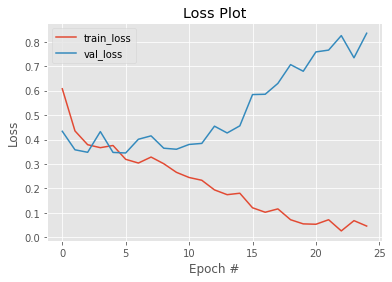

<Figure size 432x288 with 0 Axes>

In [53]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 25), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 25), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.savefig('loss-plot-cancer.png')

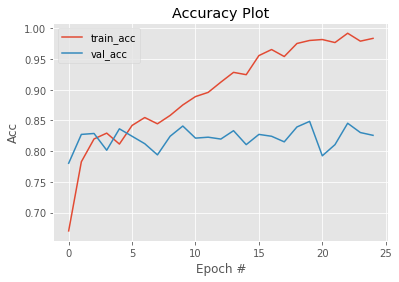

<Figure size 432x288 with 0 Axes>

In [54]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 25), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 25), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

plt.savefig('accuracy-plot-cancer.png')

In [55]:
from sklearn.metrics import classification_report

pred = model.predict(x_val)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_val, labels))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       360
           1       0.81      0.81      0.81       300

    accuracy                           0.83       660
   macro avg       0.82      0.82      0.82       660
weighted avg       0.83      0.83      0.83       660

